In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# PCA and EigenFaces Demo

In [2]:
from numpy import *
from IPython.html.widgets import *
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Performing PCA on a 2-dimensional data

We show how the principal components will be calculated from a generated Gaussian data.

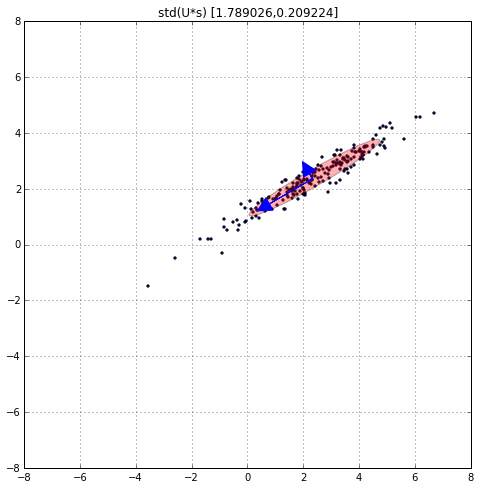

In [3]:
from numpy.random import standard_normal
from matplotlib.patches import Ellipse
from numpy.linalg import svd
@interact
def plot_2d_pca(mu_x=FloatSlider(min=-3.0, max=3.0, value=0), 
                mu_y=FloatSlider(min=-3.0, max=3.0, value=0), 
                sigma_x=FloatSlider(min=0.2, max=1.8, value=1.8),
                sigma_y=FloatSlider(min=0.2, max=1.8, value=0.3),
                theta=FloatSlider(min=0.0, max=pi, value=pi/6), center=False):
    mu=array([mu_x, mu_y])
    sigma=array([sigma_x, sigma_y])
    R=array([[cos(theta),-sin(theta)],[sin(theta),cos(theta)]])
    X=dot(standard_normal((1000, 2)) * sigma[newaxis,:],R.T) + mu[newaxis,:]

    # Plot the points and the ellipse
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(X[:200,0], X[:200,1], marker='.')
    ax.grid()
    M=8.0
    ax.set_xlim([-M,M])
    ax.set_ylim([-M,M])
    e=Ellipse(xy=array([mu_x, mu_y]), width=sigma_x*3, height=sigma_y*3, angle=theta/pi*180, 
              facecolor=[1.0,0,0], alpha=0.3)
    ax.add_artist(e)
    
    # Perform PCA and plot the vectors
    if center:
        X_mean=X.mean(axis=0,keepdims=True)
    else:
        X_mean=zeros((1,2))

    U,s,V =svd(X-X_mean, full_matrices=False)
    for v in dot(diag(s/sqrt(X.shape[0])),V): # Each eigenvector
        ax.arrow(X_mean[0,0],X_mean[0,1],-v[0],-v[1], 
                head_width=0.5, head_length=0.5, fc='b', ec='b')
        Ustd=U.std(axis=0)
        ax.set_title('std(U*s) [%f,%f]' % (Ustd[0]*s[0],Ustd[1]*s[1]))


# Performing PCA on a face dataset

First, load the CAFE or POFA dataset.

In [4]:
import pickle
dataset=pickle.load(open('cafe.pkl','r')) # or 'pofa.pkl' for POFA
disp('dataset.images shape is %s' % str(dataset.images.shape))
disp('dataset.data shape is %s' % str(dataset.data.shape))

dataset.images shape is (80, 95, 60)
dataset.data shape is (80, 5700)


View the images in the dataset.

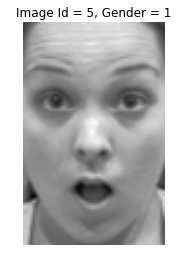

In [5]:
@interact
def plot_face(n=(0, dataset.images.shape[0]-1)):
    plt.imshow(dataset.images[n],cmap='gray')
    plt.title('Image Id = %d, Gender = %d' % (dataset.target[n], dataset.gender[n]))
    plt.axis('off')

## Performing PCA

Center and whiten data.  The first axis (`axis=0`) is the `n_samples` dimension.

In [6]:
X=dataset.data.copy() # So that we won't mess up the data in the dataset\
X_mean=X.mean(axis=0,keepdims=True) # Mean for each dimension across sample (centering)
X_std=X.std(axis=0,keepdims=True)
X-=X_mean
disp(all(abs(X.mean(axis=0))<1e-12)) # Are means for all dimensions very close to zero?

True


Perform SVD to calculate the projection matrix $V$.  By default, `U,s,V=svd(...)` returns full matrices, which will return $n \times n$ matrix `U`, $n$-dimensional vector of singular values `s`, and $d \times d$ matrix `V`.   But here, we don't really need $d \times d$ matrix `V`; with `full_matrices=False`, `svd` only returns $n \times d$ matrix for `V`.

In [7]:
from numpy.linalg import svd
U,s,V=svd(X,compute_uv=True, full_matrices=False)
disp(str(U.shape))
disp(str(s.shape))
disp(str(V.shape))

(80, 80)
(80,)
(80, 5700)


We can also plot how much each eigenvector in `V` contributes to the overall variance by plotting `variance_ratio` = $\frac{s^2}{\sum s^2}$.  (Notice that `s` is already in the decreasing order.)  The `cumsum` (cumulative sum) of `variance_ratio` then shows how much of the variance is explained by components up to `n_components`. 

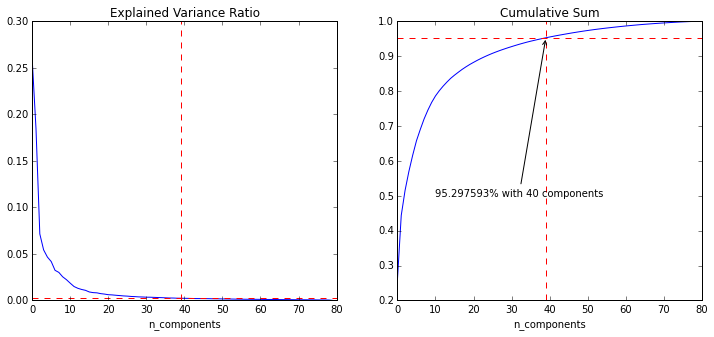

In [8]:
variance_ratio=s**2/(s**2).sum()   # Normalized so that they add to one.
@interact
def plot_variance_ratio(n_components=(1, len(variance_ratio))):
    n=n_components-1
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(variance_ratio)
    axs[0].set_title('Explained Variance Ratio')
    axs[0].set_xlabel('n_components')
    axs[0].axvline(n, color='r', linestyle='--')
    axs[0].axhline(variance_ratio[n], color='r', linestyle='--')
    
    axs[1].plot(cumsum(variance_ratio))
    axs[1].set_xlabel('n_components')
    axs[1].set_title('Cumulative Sum')
    
    captured=cumsum(variance_ratio)[n]
    axs[1].axvline(n, color='r', linestyle='--')
    axs[1].axhline(captured, color='r', linestyle='--')
    axs[1].annotate(s='%f%% with %d components' % (captured * 100, n_components), xy=(n, captured), 
                    xytext=(10, 0.5), arrowprops=dict(arrowstyle="->")) 

Plot each eigenface (eigenvectors in `V`). Note that the plot range is not from 0 to 1.

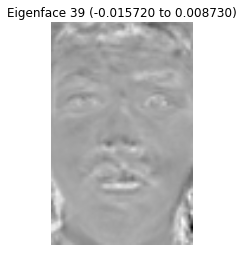

In [9]:
image_shape=dataset.images.shape[1:] # (H x W)
@interact
def plot_eigenface(eigenface=(0, V.shape[0]-1)):
    v=V[eigenface]*X_std
    
    plt.imshow(v.reshape(image_shape), cmap='gray')
    plt.title('Eigenface %d (%f to %f)' % (eigenface, v.min(), v.max()))
    plt.axis('off')

Now let's try reconstructing faces with different number of principal components (PCs)!  Now, the transformed `X` is reconstructed by multiplying by the sample standard deviations for each dimension and adding the sample mean. For this reason, even for zero components, you get a face-like image!

The rightmost plot is the "relative" reconstruction error (image minus the reconstruction squared, divided by the data standard deviations).  White is where the error is close to zero, and black is where the relative error is large (1 or more).  As you increase the number of PCs, you should see the error mostly going to zero (white).

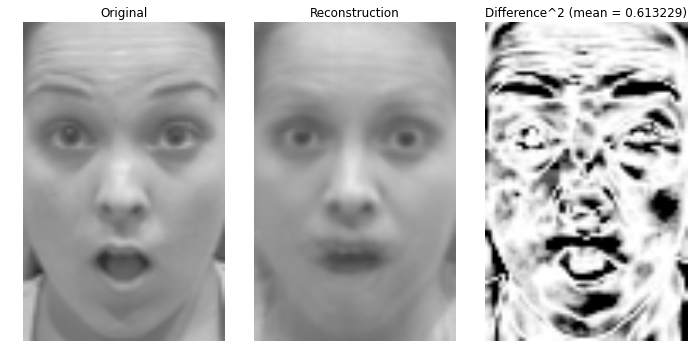

In [10]:
@interact
def reconstruct_with(n=(0,dataset.images.shape[0]-1), n_components=IntSlider(value=10, max=V.shape[0]-1)):
    # This is where we perform the projection and un-projection
    Vn=V[:n_components]
    X_hat=dot(dot(X[n], Vn.T), Vn)
    
    # Un-center
    I=X[n] + X_mean
    I_hat = X_hat + X_mean
    D=multiply(I-I_hat,I-I_hat) / multiply(X_std, X_std)
    
    # And plot
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
    axs[0].imshow(I.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[0].axis('off')
    axs[0].set_title('Original')
    
    axs[1].imshow(I_hat.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[1].axis('off')
    axs[1].set_title('Reconstruction')

    axs[2].imshow(1-D.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[2].axis('off')
    axs[2].set_title('Difference^2 (mean = %f)' % sqrt(D.mean()))
    
    plt.tight_layout()

## Image morphing

In the following, we'll morph two images by taking averages of the two images within the transformed space.

<function __main__.plot_morph>

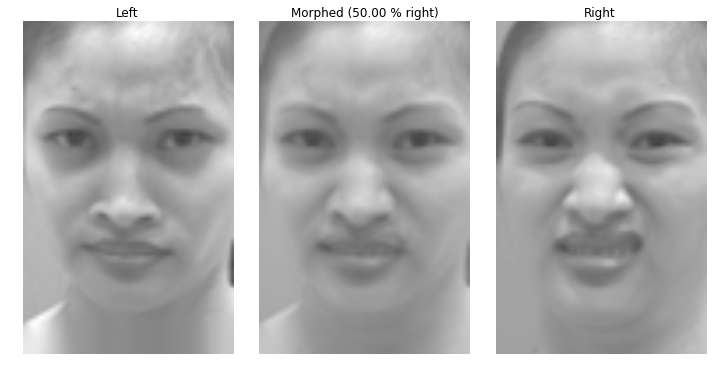

In [11]:
def plot_morph(left=0, right=1, mix=0.5):
    # Projected images
    x_lft=dot(X[left], V.T)
    x_rgt=dot(X[right], V.T)
    
    # Mix
    x_avg = x_lft * (1.0-mix) + x_rgt * (mix)
    
    # Un-project
    X_hat = dot(x_avg[newaxis,:], V)
    I_hat = X_hat + X_mean
    
    # And plot
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
    axs[0].imshow(dataset.images[left], cmap='gray', vmin=0, vmax=1)
    axs[0].axis('off')
    axs[0].set_title('Left')
    
    axs[1].imshow(I_hat.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[1].axis('off')
    axs[1].set_title('Morphed (%.2f %% right)' % (mix * 100))

    axs[2].imshow(dataset.images[right], cmap='gray', vmin=0, vmax=1)
    axs[2].axis('off')
    axs[2].set_title('Right')
    
    plt.tight_layout()

interact(plot_morph,
         left=IntSlider(max=dataset.images.shape[0]-1),
         right=IntSlider(max=dataset.images.shape[0]-1,value=1),
         mix=FloatSlider(value=0.5, min=0, max=1.0))